In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/Colab Notebooks/main_work/coco_eval.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/main_work/coco_utils.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/main_work/engine.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/main_work/train.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/main_work/utils.py" "/content"
!cp "/content/drive/MyDrive/Colab Notebooks/main_work/transforms.py" "/content"

In [3]:
import os
import random
import numpy as np
import pandas as pd

import cv2

from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [4]:
files_dir = '/content/drive/MyDrive/Data/Fruit-images-for-object-detection/train_zip/train'
test_dir = '/content/drive/MyDrive/Data/Fruit-images-for-object-detection/test_zip/test'

class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        self.imgs = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        self.classes = [_, 'apple', 'banana', 'orange']
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res = img_res/255.0

        annot_filename = img_name[:-4]+'.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        wt = img.shape[1]
        ht = img.shape[0]

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd

        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res, bboxes = target['boxes'], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)



dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = {}'.format(len(dataset)))

img, target = dataset[78]
print(img.shape, '\n', target)

length of dataset = 240
(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'labels': tensor([2, 2, 2, 2]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


In [5]:
img, target = dataset[90]
print(img.shape, '\n', target)

(224, 224, 3) 
 {'boxes': tensor([[ 37.0462,  59.8431, 181.4974, 194.9020]]), 'labels': tensor([2]), 'area': tensor([19509.4199]), 'iscrowd': tensor([0]), 'image_id': tensor([90])}


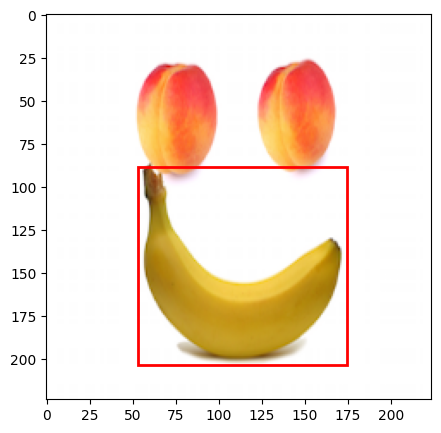

In [6]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], abs(box[2]-box[0]), abs(box[3]-box[1])
        rect = patches.Rectangle((x,y), width, height,
                                 linewidth=2, edgecolor = 'r', facecolor='none')
        a.add_patch(rect)
    plt.show()

img, target = dataset[100]
plot_img_bbox(img, target)


In [7]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [8]:
dataset = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [1]:
from torchvision.models.detection import retinanet_resnet50_fpn

model = retinanet_resnet50_fpn(weights_backbone ="DEFAULT", num_classes=4, trainable_backbone_layers=5)

In [2]:
model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [10]:
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision import ops
from torch import nn
import torchvision

def build_model2(num_classes: int):
    model = retinanet_resnet50_fpn(weights="DEFAULT")
    out_channels = model.backbone.out_channels
    anchor_generator =torchvision.models.detection.retinanet._default_anchorgen()
    head = torchvision.models.detection.retinanet.RetinaNetHead(out_channels, anchor_generator.num_anchors_per_location()[0], num_classes)
    return model


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4

model = build_model2(num_classes=num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 100MB/s]


In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/24]  eta: 0:04:03  lr: 0.000022  loss: 2.4443 (2.4443)  classification: 2.1824 (2.1824)  bbox_regression: 0.2619 (0.2619)  time: 10.1283  data: 0.3529  max mem: 6850
Epoch: [0]  [10/24]  eta: 0:00:35  lr: 0.000239  loss: 1.9312 (1.8354)  classification: 1.6848 (1.5976)  bbox_regression: 0.2445 (0.2379)  time: 2.5645  data: 0.2160  max mem: 7118
Epoch: [0]  [20/24]  eta: 0:00:08  lr: 0.000457  loss: 0.9960 (1.3415)  classification: 0.7971 (1.0888)  bbox_regression: 0.2463 (0.2527)  time: 1.8089  data: 0.1933  max mem: 7118
Epoch: [0]  [23/24]  eta: 0:00:02  lr: 0.000500  loss: 0.8744 (1.2457)  classification: 0.5264 (0.9931)  bbox_regression: 0.2489 (0.2526)  time: 1.8077  data: 0.1871  max mem: 7118
Epoch: [0] Total time: 0:00:51 (2.1511 s / it)
creating index...
index created!
Test:  [ 0/12]  eta: 0:00:05  model_time: 0.4256 (0.4256)  evaluator_time: 0.0132 (0.0132)  time: 0.4782  data: 0.0364  max mem: 7118
Test:  [11/12]  eta: 0:00:00  model_time: 0.3425 (0.3495)  ev

In [13]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [16]:
# pick one image from the test set
img, target = dataset_test[30]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  40
real #boxes:  3


EXPECTED OUTPUT


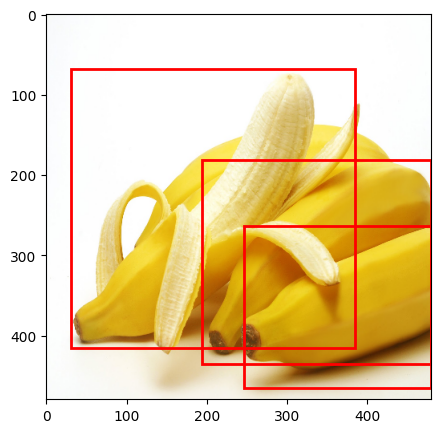

In [17]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


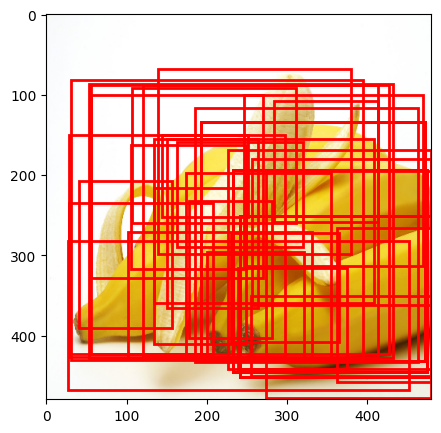

In [18]:
for x,y in prediction.items():
  prediction[x] = y.cpu()
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


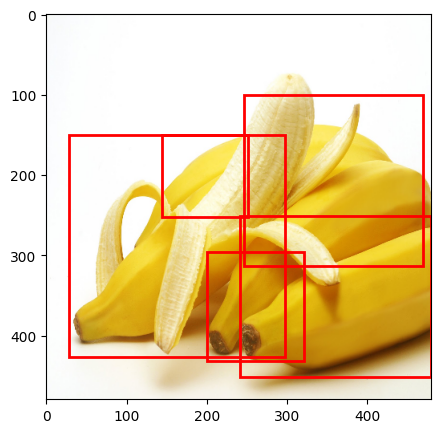

In [19]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)